In [6]:
from environments.PlantSimulator import PlantSimulator_Binary
import numpy as np
import matplotlib.pyplot as plt

In [7]:
env = PlantSimulator_Binary(num_plants=32, lag=1, stride=1, actions=[0, 1], action_effects=[1.0, 0.0])
print(env.terminal_step)

1007


#### Test different lighting policies

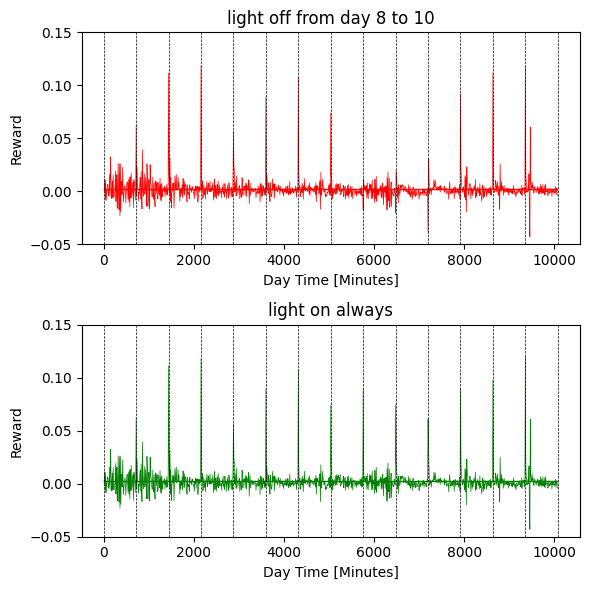

In [8]:
COLORS = ['r', 'g']
LABELS = ['light off from day 8 to 10', 'light on always']
fig, ax = plt.subplots(2, 1, figsize=(6,6))

policy1 = np.hstack([np.ones(int(env.steps_per_day*7)), np.zeros(int(env.steps_per_day*3)), np.ones(int(env.terminal_step-env.steps_per_day*10))])
policy2 = np.ones(env.terminal_step)
policy = [policy1, policy2]

for i in range(2):
    env.start()
    R = []  # reward
    State = []
    pol = policy[i]
    for _ in range(env.terminal_step):
        reward, next_state, done, info = env.step(int(pol[_]))
        R.append(reward)
        State.append(env.current_state)
    
    window_size = 1
    R = np.convolve(R, np.ones(window_size)/window_size, mode='valid')
    
    # Plot reward history
    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, R, color=COLORS[i], linewidth=0.5)
    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, np.ones(len(R))*np.mean(R), color=COLORS[i], linewidth=1)
    ax[i].set_title(LABELS[i])
    ax[i].set_xlabel('Day Time [Minutes]')
    ax[i].set_ylabel('Reward')
    ax[i].set_ylim(-0.05, 0.15)

for i in range(int(len(R)/env.steps_per_day)+2):
    ax[0].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[1].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)

fig.tight_layout()

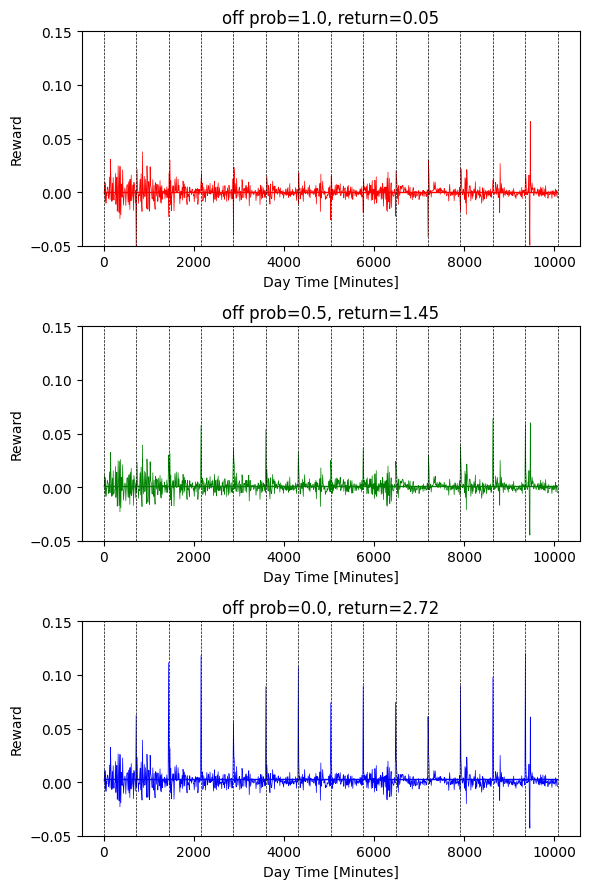

In [9]:
COLORS = ['r', 'g', 'b']
off_prob = [1, 0.5, 0]
fig, ax = plt.subplots(3, 1, figsize=(6,9))
for i in range(len(off_prob)):
    env.start()
    R = []  # reward
    for _ in range(env.terminal_step):
        reward, next_state, done, info = env.step(np.random.choice([0, 1], p=[off_prob[i], 1-off_prob[i]]))
        R.append(reward)
    
    # Plot reward history
    # Moving average (optional)
    window_size = 1
    R = np.convolve(R, np.ones(window_size)/window_size, mode='valid')

    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, R, color=COLORS[i], linewidth=0.5)
    ax[i].plot(np.arange(1, len(R)+1)*env.interval/60, np.ones(len(R))*np.mean(R), color=COLORS[i], linewidth=1)
    ax[i].set_title(f'off prob={off_prob[i]:.1f}, return={np.sum(R):.2f}')
    ax[i].set_xlabel('Day Time [Minutes]')
    ax[i].set_ylabel('Reward')
    ax[i].set_ylim(-0.05, 0.15)

for i in range(int(len(R)/env.steps_per_day)+2):
    ax[0].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[1].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)
    ax[2].axvline(x = env.steps_per_day*i*env.interval/60, color='k', linestyle='--', linewidth=0.5)

fig.tight_layout()

#### Correlation between area gain and return

return for random policy is 1.451.
max return is 2.717
min return is 0.053


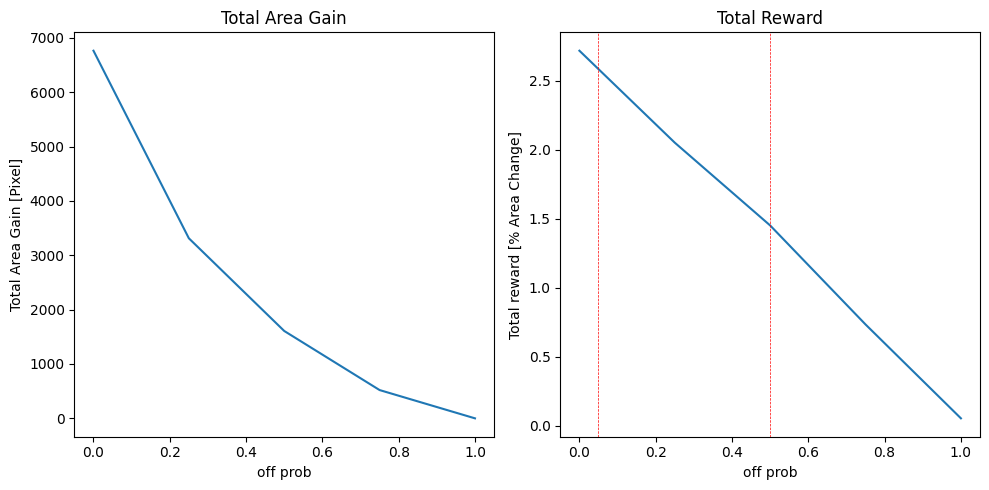

In [10]:
# See if return and total gain in area are positively correlated
num_sample = 5
episodic_return = []
area_gain = []
fig, ax = plt.subplots(1, 2, figsize=(10,5))   
for prob in np.linspace(0, 1, num_sample):
    env.start()
    R = []; A = []
    for _ in range(env.terminal_step):
        reward, next_state, done, info = env.step(np.random.choice([0, 1], p = [prob, 1-prob]))
        A.append(np.mean([pwl(env.time) for pwl in env.actual_areas]))
        R.append(reward)
    if prob == 0.5: 
        print(f'return for random policy is {np.sum(R):.3f}.')
    episodic_return.append(np.sum(R))
    area_gain.append(A[-1]-A[0])

print(f'max return is {np.max(episodic_return):.3f}')
print(f'min return is {np.min(episodic_return):.3f}')

ax[0].plot(np.linspace(0, 1, num_sample), area_gain)
ax[0].set_title('Total Area Gain')
ax[0].set_xlabel('off prob')
ax[0].set_ylabel('Total Area Gain [Pixel]')

ax[1].plot(np.linspace(0, 1, num_sample), episodic_return)
ax[1].axvline(x = 0.1/2, color='r', linestyle='--', linewidth=0.5)
ax[1].axvline(x = 0.5, color='r', linestyle='--', linewidth=0.5)
ax[1].set_title('Total Reward')
ax[1].set_xlabel('off prob')
ax[1].set_ylabel('Total reward [% Area Change]')

fig.tight_layout()